# Introduction

This notebook shows how to use model free clear sky detection.  There are three algorithms available for clear sky detection in the `ModelFreeDetect` class (standard, mean, democratic).  Each method is applied to two data sets.  The results are compared to PV_Lib's clear sky detection as a comparison to a well established method.  This notebook also shows how to process/filter data based on irradiance and measures of central tendency/deviation using the `deviation_time_filter` method.

# Setup

## Imports, config, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import model_free
# import preprocess

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings
warnings.simplefilter('ignore')


## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/.  This data is being used because it was already downloaded for a different notebook.  Irradiance data is also measured on a minute-to-minute basis.

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 50] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 50] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], 
                                                  end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
snl_data = load_snl()
srrl_data = load_srrl()

## PVLib

In [5]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [6]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 
              'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [7]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 
               'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Analysis functions

In [8]:
def pvlib_compare_plot(sample, mf, pvlib, title=''):
    size = 15
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5))

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[mf & ~pvlib], sample[mf & ~pvlib], 
                   facecolor='none', edgecolor='green', label='model free', s=size)
    _ = ax.scatter(sample.index[pvlib & ~mf], sample[pvlib & ~mf], 
                   facecolor='none', edgecolor='red', label='pvlib', s=size)
    _ = ax.scatter(sample.index[pvlib & mf], sample[pvlib & mf], 
                   facecolor='none', edgecolor='orange', label='both', s=size)
    _ = ax.legend()
    _ = ax.set_ylabel('GHI / W/m^2')
    ax.set_title(title, fontsize='large')
    
    tmp_df = pd.DataFrame()
    tmp_df['model free'] = mf
    tmp_df['pvlib'] = pvlib
    tmp_df = tmp_df.resample('D').mean()
    tmp_df.index = tmp_df.index.date
    tmp_df.plot(kind='bar', ax=axes[1])
    _ = axes[1].set_ylabel('Pct of day clear')
    
    fig.tight_layout()


In [9]:
def mf_compare_plot(standard, mean, democratic, pvlib, title=''):
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 2.5))
    
    tmp_df = pd.DataFrame()
    tmp_df['standard'] = standard
    tmp_df['mean'] = mean
    tmp_df['democratic'] = democratic
    tmp_df['pvlib'] = pvlib
    tmp_df = tmp_df.resample('D').mean()
    tmp_df.index = tmp_df.index.date
    tmp_df.plot(kind='bar', ax=axes)
    _ = axes.set_ylabel('Pct of day clear')
    
    fig.tight_layout()


In [10]:
def metric_plot(sample, metric):
    fig, ax = plt.subplots(figsize=(10, 2.5))
    
    _ = ax.plot(sample.index, sample,zorder=11)
    p = ax.scatter(sample.index, sample, c=metric, cmap=matplotlib.cm.YlOrRd, s=15, zorder=10)
    fig.colorbar(p)

# Investigation

## Sandia RTC

In [11]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-15')]

### Generate model clear sky irradiance and detect clear skies in sample using PVLib functionality.

In [12]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
pvlib_clear, components, alpha = \
    pvlib.clearsky.detect_clearsky(sample, clear_skies, 
                                   sample.index, 10, return_components=True)

### Detect clear skies using standard model free approach.

In [13]:
mf = model_free.ModelFreeDetect(sample)

In [14]:
standard_clear = mf.standard_detection()

<IPython.core.display.Javascript object>


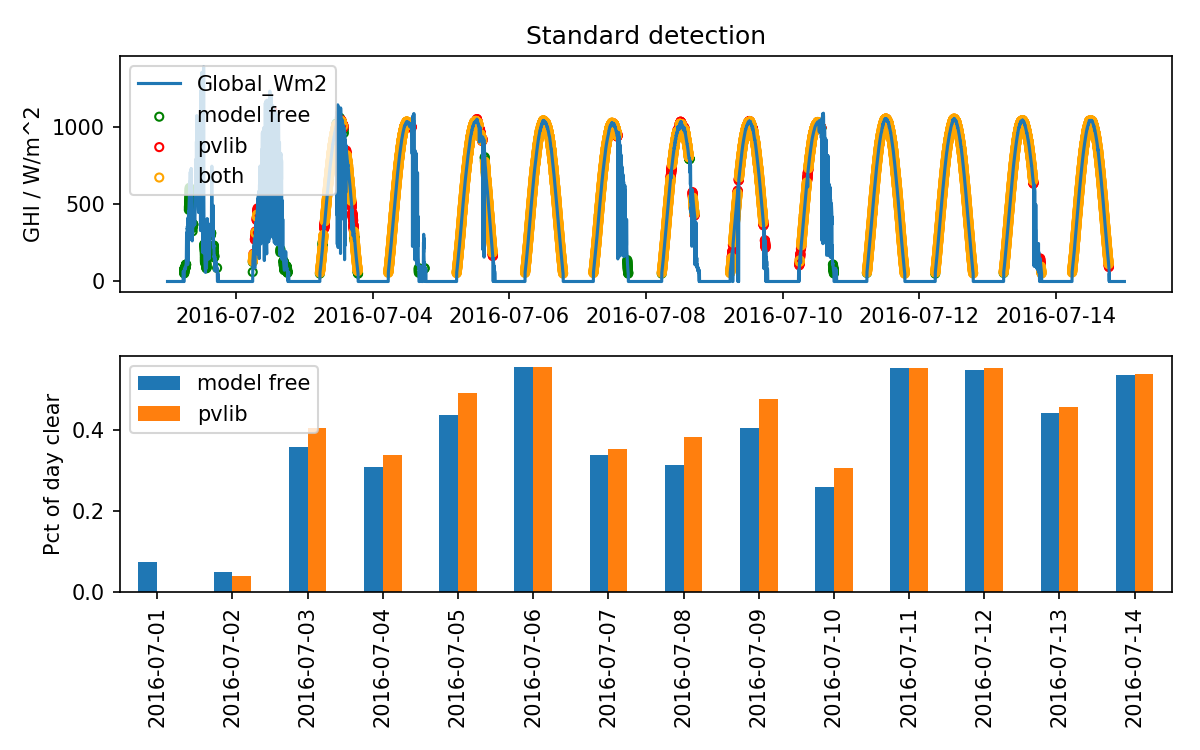

In [15]:
pvlib_compare_plot(sample, standard_clear, pvlib_clear, title='Standard detection')

We see that the model free approach is a bit too generous with clear sky labeling.  This can be controlled by using other methods provided by the ModelFreeDetect class.  They will be shown below.

### Detect clear skies using mean method model free approach

In [16]:
mean_clear = mf.mean_detection()

<IPython.core.display.Javascript object>


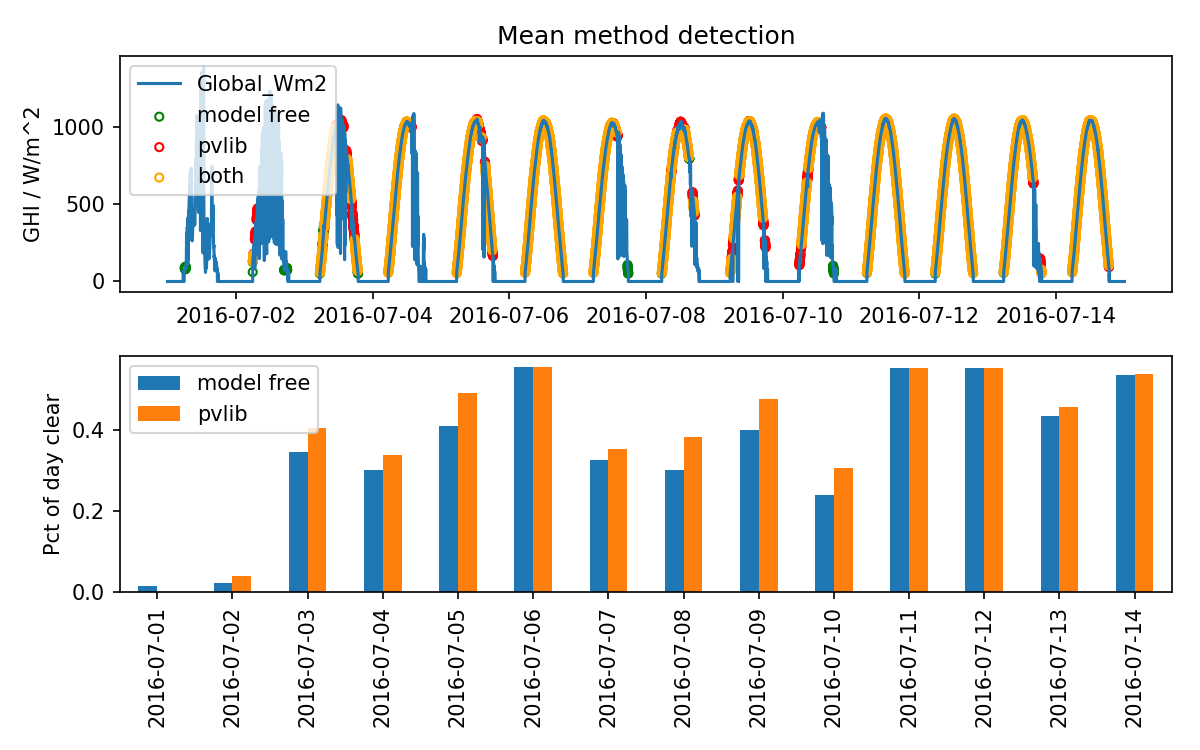

In [17]:
pvlib_compare_plot(sample, mean_clear, pvlib_clear, title='Mean method detection')

It looks like the mean method approach is a slightly more conservative when labeling clear sky periods, but it's hard to tell from this plot.  A couple figures down is a summary that compares the model free methods.

### Detect clear skies using democratic model free approach

In [18]:
democratic_clear = mf.democratic_detection()

<IPython.core.display.Javascript object>


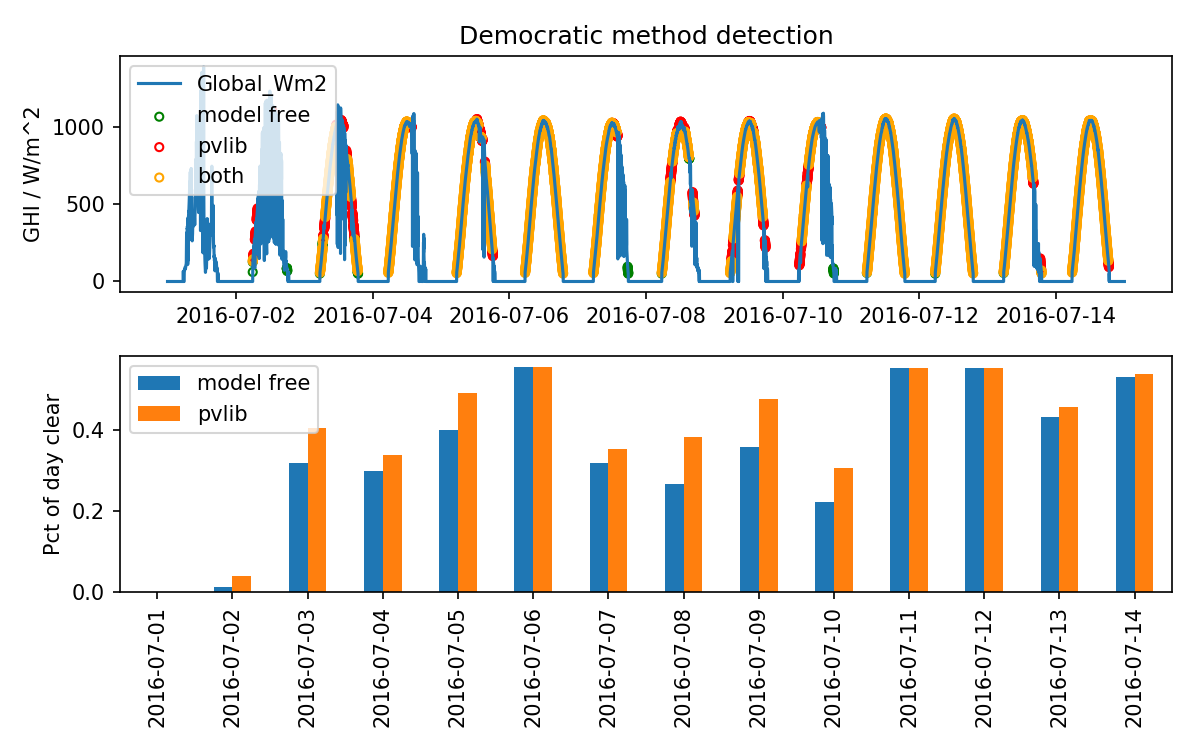

In [19]:
pvlib_compare_plot(sample, democratic_clear, pvlib_clear, title='Democratic method detection')

Again, it's hard to see how this method stacks up versus others.  Next image will summarize and compare the model free approaches.

### Model free comparison

<IPython.core.display.Javascript object>


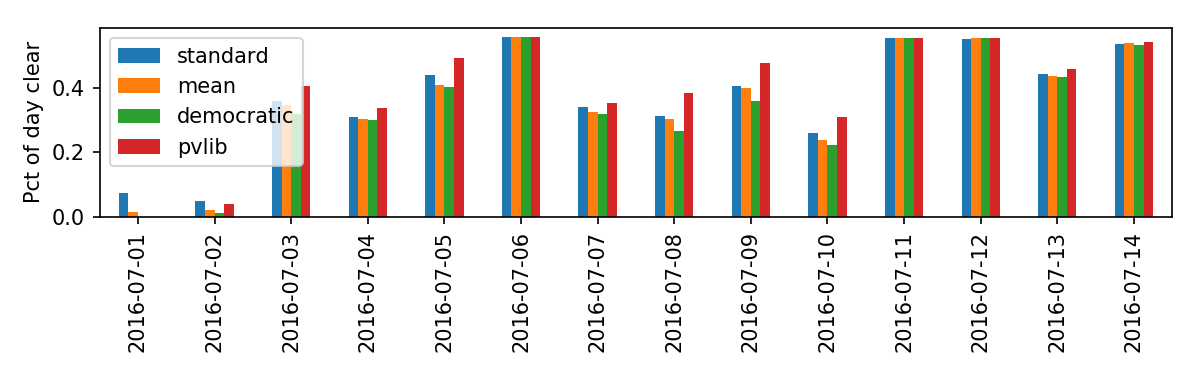

In [20]:
mf_compare_plot(standard_clear, mean_clear, democratic_clear, pvlib_clear)

We see that of clear sky labeling is most generous using the standard method, is less so with the mean method, and is most strict using the democratic method.  We also see that performance is fairly similar to that of PV_Lib.  Usually, the model free approach selects more clear periods than PV_Lib's method.  Looking at the above charts, it seems that tis is likely due to early mornings and late evenings.  It's possible that these times of very low irradiance could simply be removed if they are problematic.

### Cloudiness metric

The cloudiness metric can be returned by using `verbose=True` option for the detection methods.  This will be shown below as an illustrative example.

In [21]:
democratic_clear, components = mf.democratic_detection(verbose=True)

In [22]:
components.keys()

Index(['local_distances', 'local_integrals', 'metric'], dtype='object')

<IPython.core.display.Javascript object>


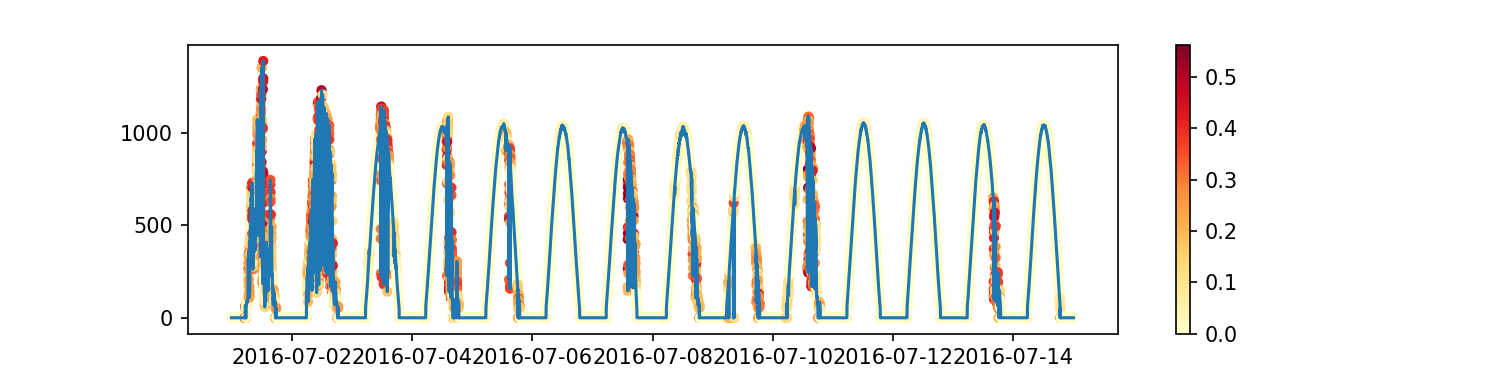

In [23]:
metric_plot(sample, components['metric'])

Later on, data will be filtered which sets values to -inf of the sample curve.  Filtering the data this way will cause nan/inf to show up in the 'metric' series, so the above plot may not display as expected.

## Solar Radiation Research Lab BMS

In [24]:
sample = srrl_data[(srrl_data.index >= '2014-01-01') & (srrl_data.index < '2014-01-15')]

### Generate model clear sky irradiance and detect clear skies in sample using PVLib functionality.

In [25]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
pvlib_clear, components, alpha = \
    pvlib.clearsky.detect_clearsky(sample, clear_skies, 
                                   sample.index, 10, return_components=True)

### Detect clear skies using standard model free approach.

In [26]:
mf = model_free.ModelFreeDetect(sample)

In [27]:
standard_clear = mf.standard_detection()

<IPython.core.display.Javascript object>


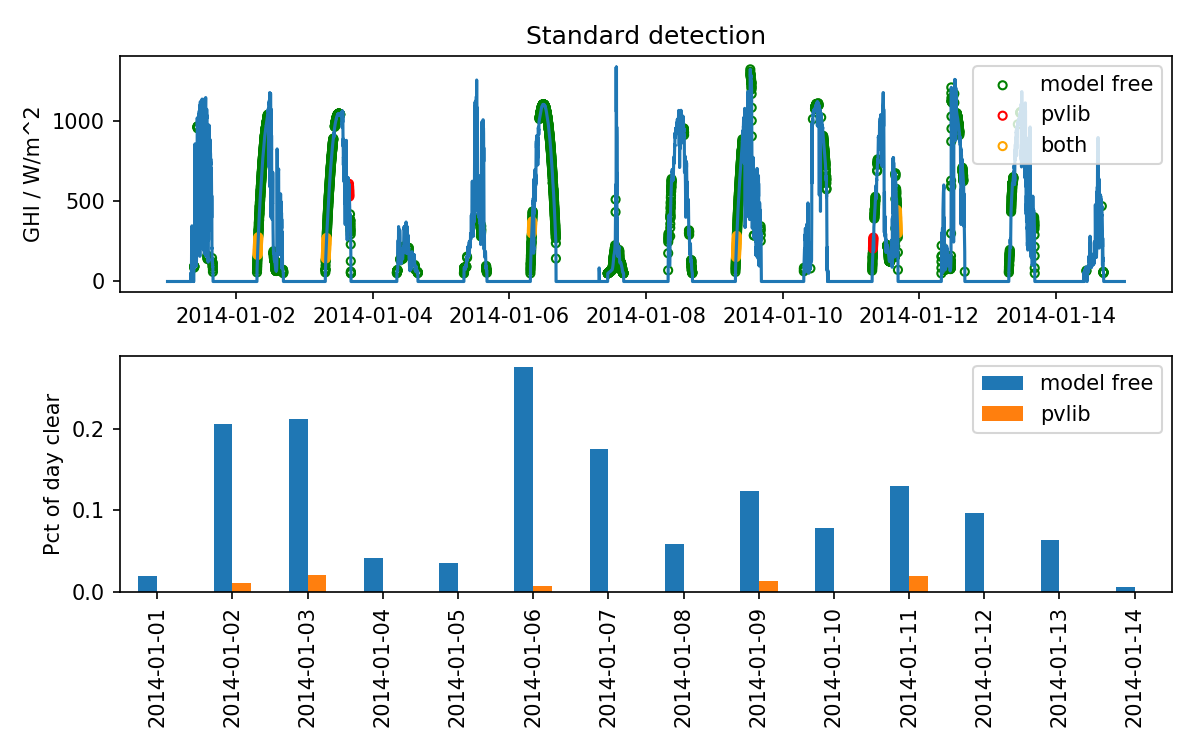

In [28]:
pvlib_compare_plot(sample, standard_clear, pvlib_clear, title='Standard detection')

First thing we notice is that PV_Lib performs very poorly at this site (using the same parameters from the Sandia RTC site).  Getting PV_Lib to properly detect clear skies could be a difficult task given there are five parameters to tune. The model free approach works better, but also includes obviously wrong clear sky labels (i.e. Jan 4th, 7th).  We will see if the mean method or the democratic method fix our problem.

### Detect clear skies using mean method model free approach

In [29]:
mean_clear = mf.mean_detection()

<IPython.core.display.Javascript object>


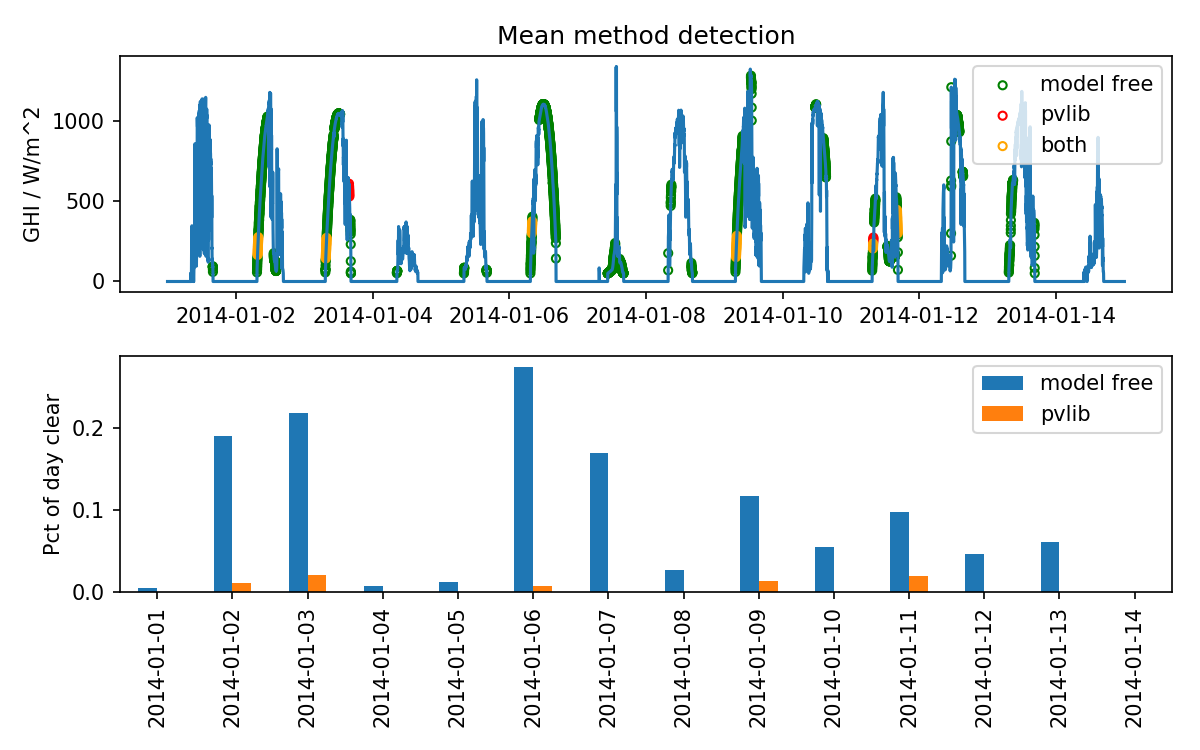

In [30]:
pvlib_compare_plot(sample, mean_clear, pvlib_clear, title='Mean method detection')

If there is any improvement over the standard method, it anecdotal at best.

### Detect clear skies using democratic model free approach

In [31]:
democratic_clear = mf.democratic_detection()

<IPython.core.display.Javascript object>


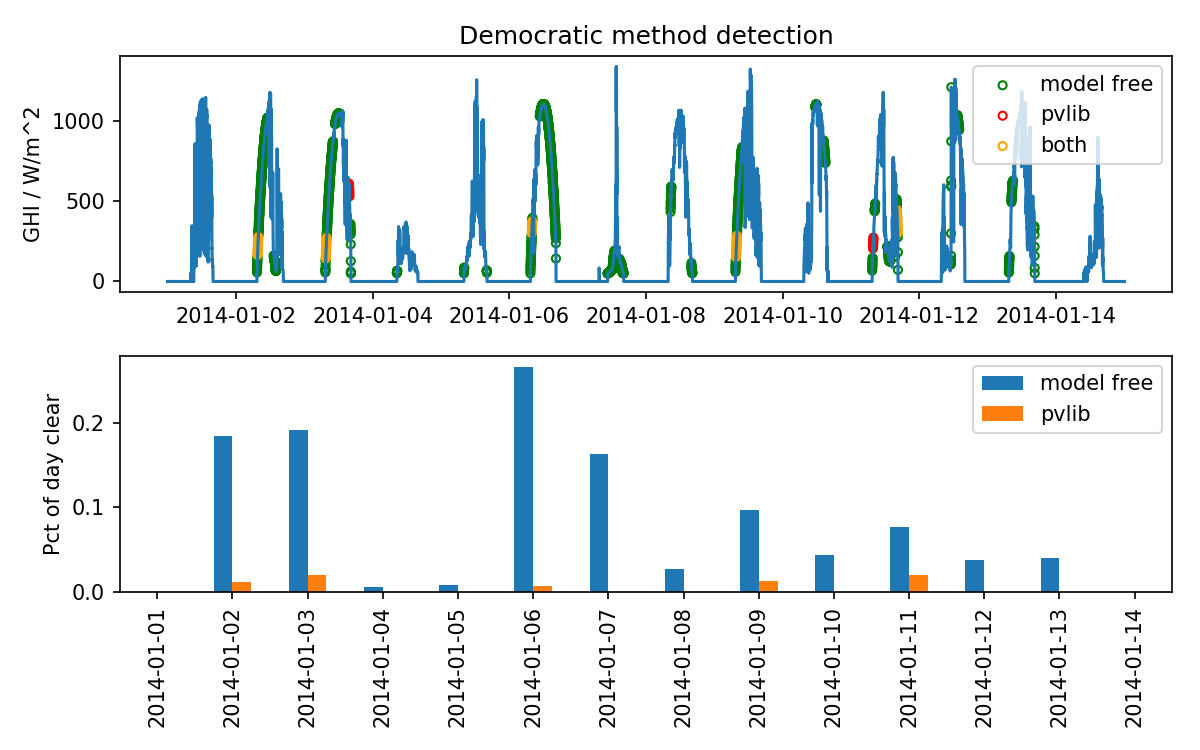

In [32]:
pvlib_compare_plot(sample, democratic_clear, pvlib_clear, title='Democratic method detection')

Again, we struggle with this data set.  It appears that this method struggles where there are extended periods of low irradiance (specifically looking at Jan 7th here).

### Model free comparison

<IPython.core.display.Javascript object>


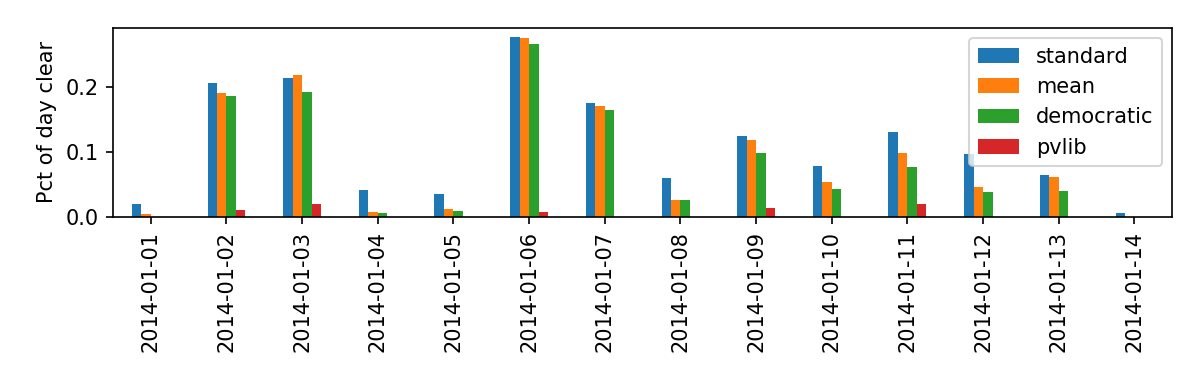

In [33]:
mf_compare_plot(standard_clear, mean_clear, democratic_clear, pvlib_clear)

We see the same trend in frequency of clear skies detected from the previous sample.  It's clear we need a way to remove some of these problematic time periods.

### Filtering data

The deviation_time_filter method provides a few methods for removing time periods that are problematic for the model free detection method.  This example will show the default settings, which removes points based on their relative deviation from the mean at a given time (anything less than 80% of the mean at a given minute during the day will be removed).

**NOTE** this method modifies the irradiance data.  If you want the original data back, reinstantiate the object.

In [34]:
mf.deviation_time_filter()

### Detect clear skies using standard model free approach.

In [35]:
standard_clear = mf.standard_detection()

<IPython.core.display.Javascript object>


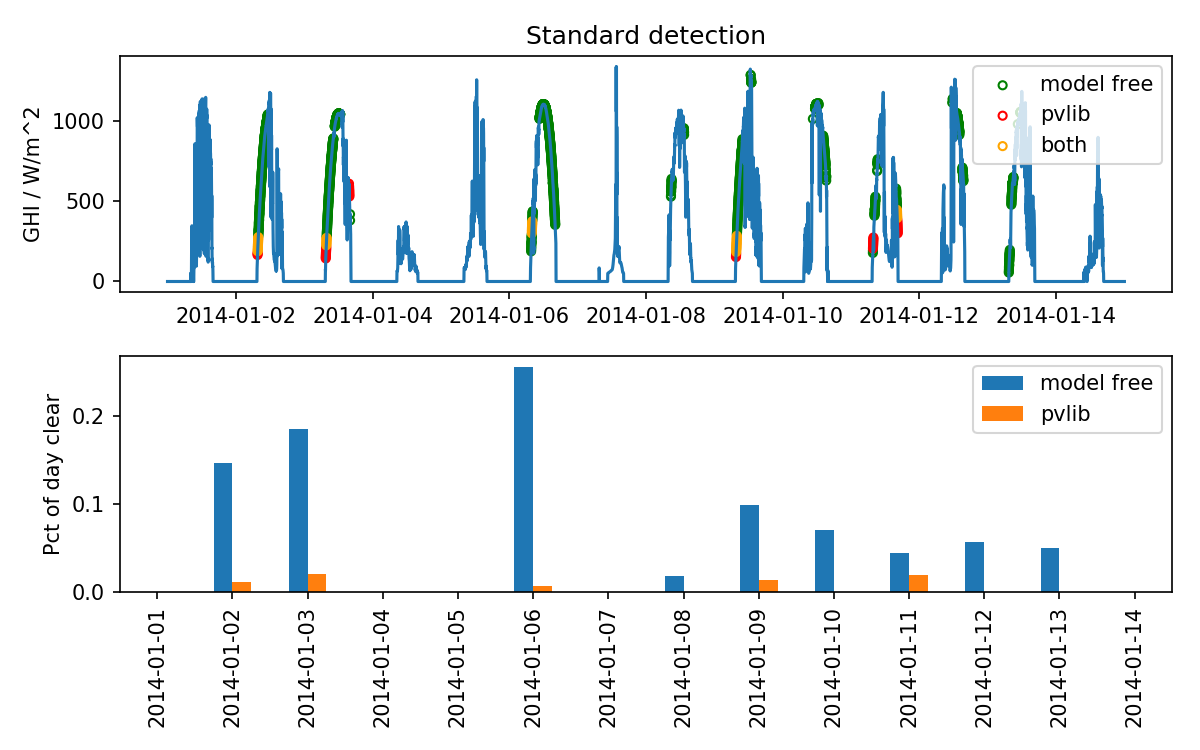

In [36]:
pvlib_compare_plot(sample, standard_clear, pvlib_clear, title='Standard detection')

Using the deviation time filter improves results dramatically.  

### Detect clear skies using mean method model free approach

In [37]:
mean_clear = mf.mean_detection()

<IPython.core.display.Javascript object>


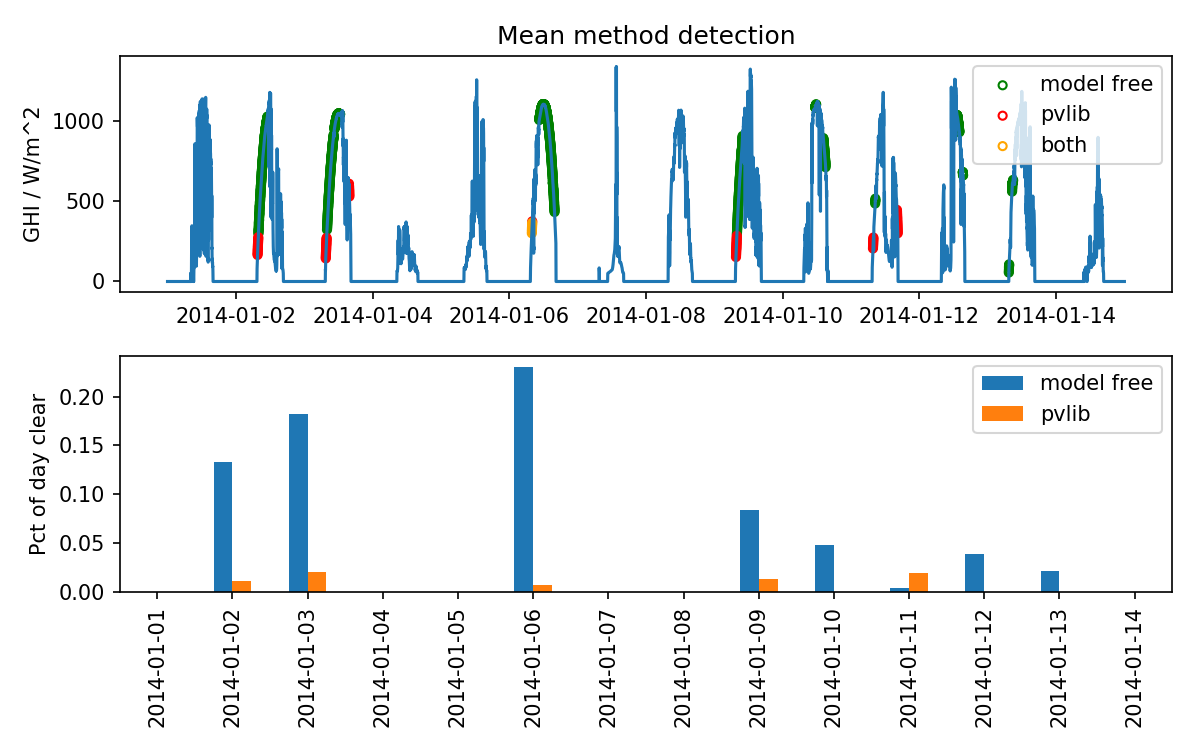

In [38]:
pvlib_compare_plot(sample, mean_clear, pvlib_clear, title='Mean method detection')

Mean method also sees improvement.

### Detect clear skies using democratic model free approach

In [39]:
democratic_clear = mf.democratic_detection()

<IPython.core.display.Javascript object>


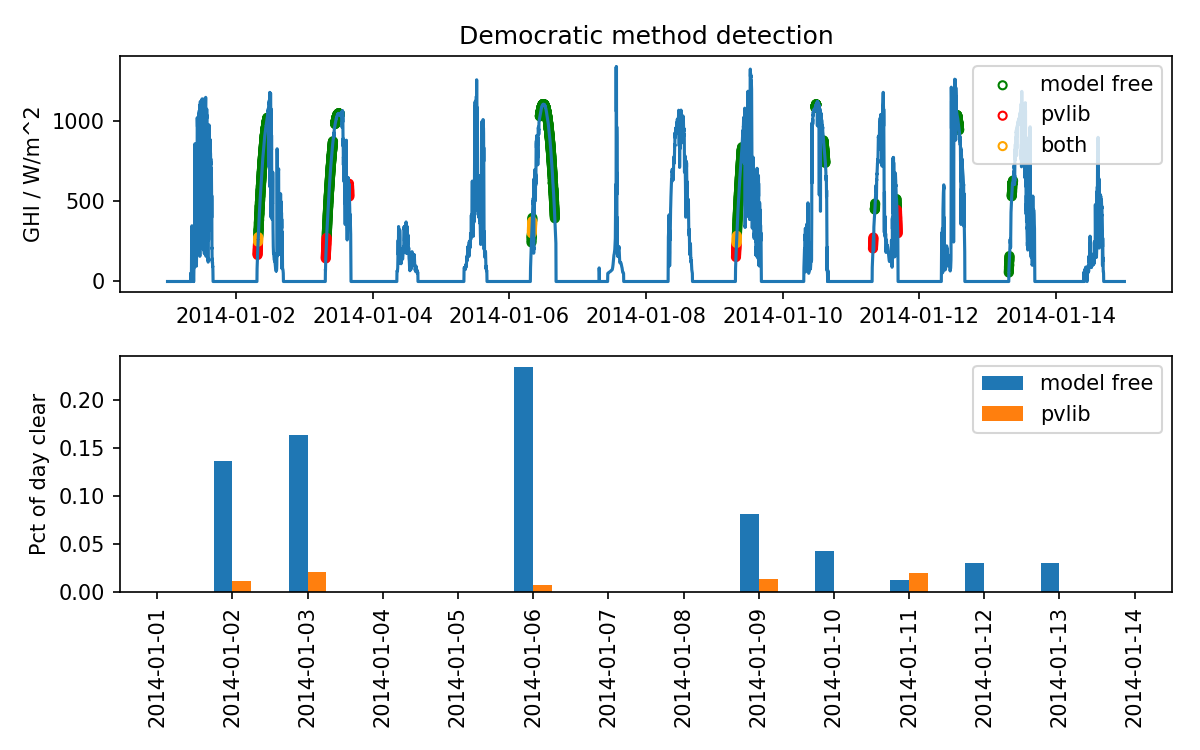

In [40]:
pvlib_compare_plot(sample, democratic_clear, pvlib_clear, title='Democratic method detection')

Democratic method improves as well.

### Model free comparison

<IPython.core.display.Javascript object>


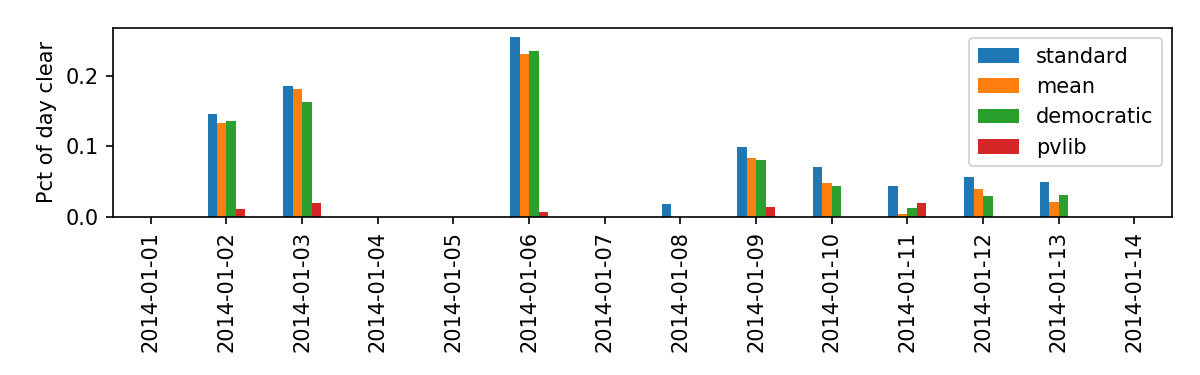

In [41]:
mf_compare_plot(standard_clear, mean_clear, democratic_clear, pvlib_clear)

Removing measurements at points during the day that deviated too far from the population mean of measurements at that time works well.  We saw that it led to much more accurate and strict labeling of clear sky days.

# Conclusion






This notebook showed how to use the `ModelFreeDetect` class to identify periods of clear skies.  The three algorithms presented are all useful, though the mean method and democratic method behave more similarly to PV_Lib detection.  While these methods proved useful on the Sandia RTC data, we saw it struggle with the Solar radiation research lab data. They specifically struggled during periods of prolonged cloudiness.  To address this, data can be filtered and processed using the `deviation_time_filter`.